<a href="https://colab.research.google.com/github/Jsk10101/PlanetarySci-Phys5205/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports and mounting drive

In [ ]:
import astropy.units as u
import astropy.constants as ac
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Measure Planet Mass Based On Radial Velocity Data
This section explores the GJ 436 Planet and it's radial velocity data

To begin, we first open the data file and convert it into a dataframe using the `pandas` package. This is appreviated as `pd` in our code.

In [ ]:
with open('/content/drive/My Drive/Presentation 2/Data Files/GJ436-RV.tbl.txt', 'r') as file:
        lines = file.readlines()
lines = lines[22:]
data = [line.strip().split('        ') for line in lines] # Assuming space-separated values
df_RV = pd.DataFrame(data)
df_RV.columns = ['BJD', 'RV', '', '', 'RV Uncertainty']
df_RV['BJD'] = df_RV['BJD'].astype(float)
df_RV['RV'] = df_RV['RV'].astype(float)
df_RV['RV Uncertainty'] = df_RV['RV Uncertainty'].astype(float)
print(df_RV)

            BJD     RV      RV Uncertainty
0   2451552.077   5.84                 2.3
1   2451583.948   0.67                 2.0
2   2451706.865 -12.05                 2.6
3   2451983.015   9.48                 2.8
4   2452064.871  12.76                 2.9
5   2452308.084  19.86                 2.5
6   2452333.038 -26.89                 3.4
7   2452334.054  17.15                 2.4
8   2452334.935  -1.45                 2.7
9   2452363.039  13.43                 2.9
10  2452681.057  11.36                 2.9
11  2452711.898   0.00                 2.4
12  2452712.902   5.14                 2.7
13  2452804.878  18.86                 2.6
14  2452805.829  -7.21                 2.4
15  2452828.800  14.85                 2.5
16  2452832.758 -21.88                 2.4
17  2452833.763  13.01                 2.4
18  2452834.779  -3.56                 3.0
19  2452848.752 -21.18                 2.6
20  2452849.762  17.95                 2.1
21  2452850.764  -3.77                 2.1
22  2452988

With this complete, we now plot our RV data to see all of our data values on a plot.

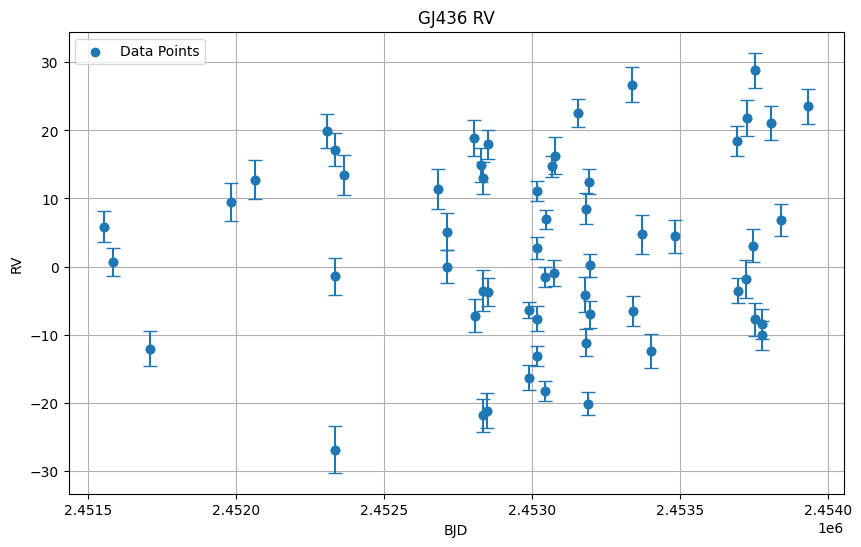

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_RV["BJD"], df_RV["RV"], label = 'Data Points')
ax.errorbar(df_RV["BJD"], df_RV["RV"], yerr=df_RV["RV Uncertainty"], fmt='o', capsize=5)
ax.grid(True)
ax.legend()
ax.set_xlabel('BJD')
ax.set_ylabel('RV')
ax.set_title('GJ436 RV')
plt.show()

Let us first clean this data to a range of $2σ$ to improve measurements.

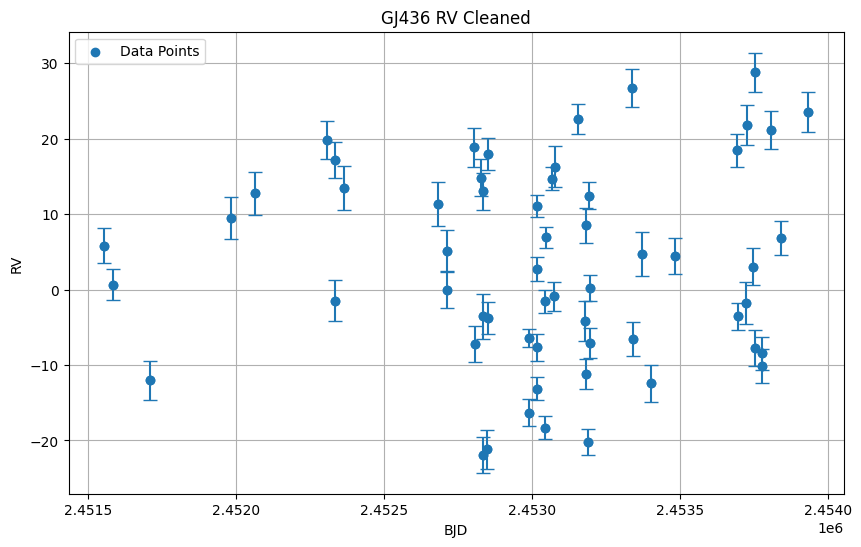

In [ ]:
# Statistics of Data

mean_RV = np.mean(df_RV["RV"])
std_RV = np.std(df_RV["RV"])

# Filter using Data Stats
df_RV_filtered = df_RV[np.abs(df_RV["RV"] - mean_RV) <= 2 * std_RV]

# Plot to see changes
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_RV_filtered["BJD"], df_RV_filtered["RV"], label = 'Data Points')
ax.errorbar(df_RV_filtered["BJD"], df_RV_filtered["RV"], yerr=df_RV_filtered["RV Uncertainty"], fmt='o', capsize=5)
ax.grid(True)
ax.legend()
ax.set_xlabel('BJD')
ax.set_ylabel('RV')
ax.set_title('GJ436 RV Cleaned')
plt.show()

In [ ]:
# Checking how many points filtering eliminates
print(len(df_RV)- len(df_RV_filtered))

1


Now to actually begin this, we must find one major parameter to begin our project, this being the period $T$. This can be done by using a *Lomb Scargle Periodogram*, which is a graph that determines period through uneven spaced data such as our Radial Velocity data. From this, we can get a relatively good estimate for our period.

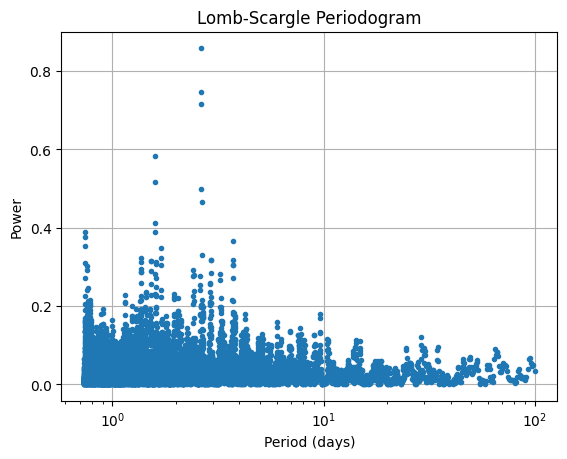

Estimated Period: 2.6438 days


In [ ]:
from astropy.timeseries import LombScargle
import numpy as np
import matplotlib.pyplot as plt

# Initialize Data Values
x_data = df_RV_filtered["BJD"]
y_data = df_RV_filtered["RV"]
y_error = df_RV_filtered["RV Uncertainty"]

# Create Adjustable periods for frequency
per_min = 0.7333
per_max = 100

# Create Frequency for Periodogram
frequency = np.linspace(1 / per_max,1 / per_min, 10000)

# Calculate the Lomb-Scargle periodogram
power = LombScargle(x_data, y_data, y_error).power(frequency)

plt.plot(1/ frequency, power, ".")
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.xscale('log')
plt.title('Lomb-Scargle Periodogram')
plt.grid(True)
plt.show()

# Estimate Period
period = 1 / frequency[np.argmax(power)]
print(f"Estimated Period: {period:.4f} days")

Now that we have our Period in place, we can utilize this Period to improve our estimation of a given $K$ value using some fitting strategies. We will be using the package `radvel` to help us with this fitting procedure.

Keep in mind that most of these values will be eyeballed so our values may be off from the original values that utilize this data.

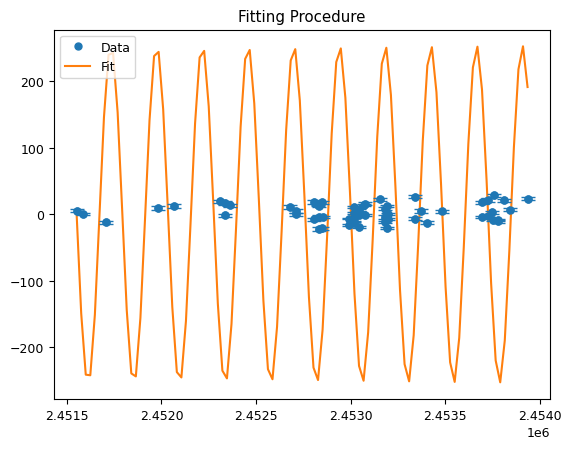

Period: 2.64
Epoch of Periastron: 2451552.08
Eccentricity: 0.00
Omega: 1.57
Semi-Amplitude: 253.63


In [ ]:
# Trying to find an RV that best fits the data
# Begin by trying on the whole sample
import radvel
import numpy as np

# Initial guessing parameters
m_p = 1.0
m_s = 0.441167 # Assume Stellar Mass is already known for ease of calculation
per = 2.6438 # Units of Days
t0 = 2451552.077
ecc = 0 # Assume circular eccentricity for whole project
omega = np.pi / 2 #
K = radvel.utils.semi_amplitude(m_p, per, m_s, ecc, Msini_units = "jupiter")
# Initialize Data
x_data = df_RV_filtered["BJD"]
y_data = df_RV_filtered["RV"]
# Guessing List
initial_guess = [per, t0, ecc, omega, K]
# Fitting data
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = radvel.kepler.rv_drive(x_fit, initial_guess, use_c_kepler_solver = False)
# Plot
plt.plot(x_data, y_data, 'o', label='Data',)
plt.plot(x_fit, y_fit, '-', label='Fit')
plt.errorbar(df_RV_filtered["BJD"], df_RV_filtered["RV"], yerr=df_RV_filtered["RV Uncertainty"], fmt='o', capsize=5, color = "tab:blue")
plt.legend()
plt.title("Fitting Procedure")
plt.show()
print(f"Period: {per:.2f}")
print(f"Epoch of Periastron: {t0:.2f}")
print(f"Eccentricity: {ecc:.2f}")
print(f"Omega: {omega:.2f}")
print(f"Semi-Amplitude: {K:.2f}")

The fit is complete, however, we must fine tune this fit in order to find an appropriate period to solve for semi-amplitude and eventually mass of planet.

First thing we can do to tune this fit is to reduce the semi-amplitude, as that is the main contributer to the difference between the data and the fit for the time being. This can be done by reducing the $M × sin(i)$ from Jupiter mass to Earth mass, as to reduce the stretch of the fit.

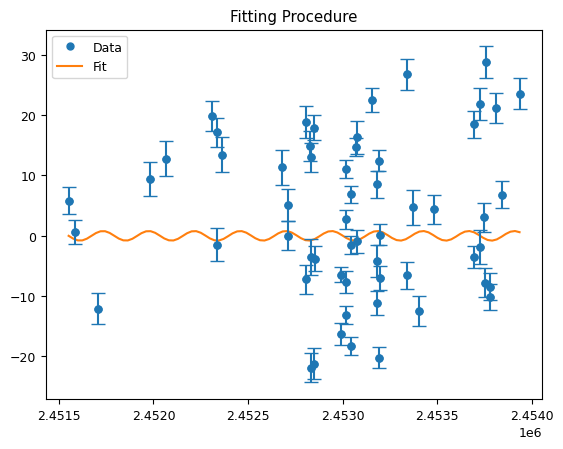

Period: 2.64
Epoch of Periastron: 2451552.08
Eccentricity: 0.00
Omega: 1.57
Semi-Amplitude: 0.80


In [ ]:
# Changed guessing parameters
m_p = 1.0
m_s = 0.441167 # Assume Stellar Mass is already known for ease of calculation
per = 2.6438 # Units of Days
t0 = 2451552.077
ecc = 0 # Assume circular eccentricity for whole project
omega = np.pi / 2 #
K = radvel.utils.semi_amplitude(m_p, per, m_s, ecc, Msini_units = "Earth")
# Guessing List
new_guess = [per, t0, ecc, omega, K]
# Fitting data
new_x_fit = np.linspace(min(x_data), max(x_data), 100)
new_y_fit = radvel.kepler.rv_drive(x_fit, new_guess, use_c_kepler_solver = False)
# Plot
plt.plot(x_data, y_data, 'o', label='Data')
plt.plot(new_x_fit, new_y_fit, '-', label='Fit')
plt.errorbar(df_RV_filtered["BJD"], df_RV_filtered["RV"], yerr=df_RV_filtered["RV Uncertainty"], fmt='o', capsize=5, color = "tab:blue")
plt.legend()
plt.title("Fitting Procedure")
plt.show()
print(f"Period: {per:.2f}")
print(f"Epoch of Periastron: {t0:.2f}")
print(f"Eccentricity: {ecc:.2f}")
print(f"Omega: {omega:.2f}")
print(f"Semi-Amplitude: {K:.2f}")

Here, we see that the semi-amplitude $K$ is too small, leading two assumptions. One is that either the planet or star mass is too small for this fit. The other is that omega might need to be changed according to the date of observation. We will fix both accordingly to make for a reasonable $K$ value. We gain basic data such as eccentricity and Mass of sun from the detailed parameters provided [here](https://exoplanet.eu/catalog/gj_436_b--241/).

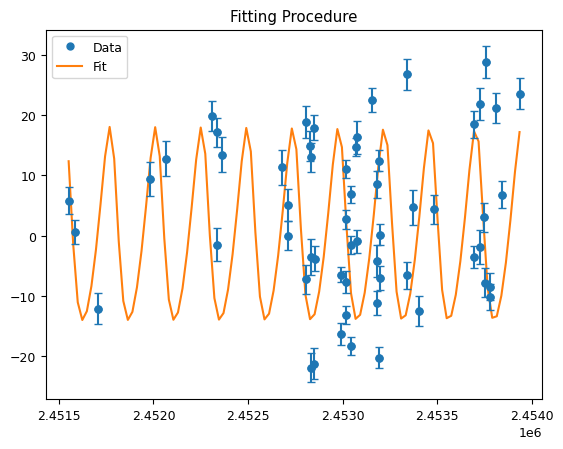

Period: 2.64 days
Epoch of Periastron: 2451552.08 JD
Eccentricity: 0.20
Omega: 0.87 radians
Semi-Amplitude: 16.03 m / s


In [ ]:
# Changed guessing parameters
m_p = 20
m_s = 0.452 # Assume Stellar Mass is already known for ease of calculation
per = 2.6438 # Units of Days
t0 = 2451552.077
ecc = 0.2 # Eccentricity
omega = 50 * np.pi/180 # Convert Degrees to Radians
K = radvel.utils.semi_amplitude(m_p, per, m_s, ecc, Msini_units = "Earth")
# Guessing List
new_guess = [per, t0, ecc, omega, K]
# Fitting data
new_x_fit = np.linspace(min(x_data), max(x_data), 100)
new_y_fit = radvel.kepler.rv_drive(x_fit, new_guess, use_c_kepler_solver = False)
# Plot
plt.plot(x_data, y_data, 'o', label='Data')
plt.plot(new_x_fit, new_y_fit, '-', label='Fit')
plt.errorbar(df_RV_filtered["BJD"], df_RV_filtered["RV"], yerr=df_RV_filtered["RV Uncertainty"], fmt='o', capsize=3, color = "tab:blue")
plt.legend()
plt.title("Fitting Procedure")
plt.show()
print(f"Period: {per:.2f} days")
print(f"Epoch of Periastron: {t0:.2f} JD")
print(f"Eccentricity: {ecc:.2f}")
print(f"Omega: {omega :.2f} radians")
print(f"Semi-Amplitude: {K:.2f} m / s")

This $K$ value seems to be an appropriate fit for our data, so we will use a quick equation to verify the estimated Planetary Mass. We will be using our $K$ value in the below equation to do this:
$$
K = \frac{M_p}{M_⋆+M_p}\frac{na \sin(i)}{\sqrt{1-e^2}}
$$
The parameters for this equation include the Mass of the planet $M_p$, Mass of the star $M_⋆$ mean anomaly $n$, semi-major axis $a$, inclination angle $i$, and finally eccentricity $e$.

One simple assumption we can make about this equation is that the mass of the star $M_⋆ \gt\gt M_p$, effectively removing the $M_p$ from the denominator of this equation. Another is that the inclination angle $i$ for a given planet that can provide transiting data is $≈ 90^°$, making $\sin(i) = 1$.

With this, we can use some quick equations such as Kepler's third law: $a = (\frac{GM_⋆T^2}{4π^2})^{\frac{1}{3}}$ and mean anomaly equation: $n = \frac{2π}{T}$ to make more known values available.

Now, we can isolate $M_p$ to create the equation below:
$$
M_p = \frac{K M_⋆ \sqrt{1-e^2}}{\frac{2π}{T}(\frac{GM_⋆T^2}{4π^2})^{\frac{1}{3}}}
$$

With this, we can create our equation in our code very simply.

In [ ]:
# Changing Parameter
K = 16.03 * u.m / u.s # meters per second

# Define function for Planetary Mass
def P_mass_simple(K):
  """
  Creates the equation to find the mass of the planet using Semi-amplitude.
  """
  # Parameters
  T = 2.6438 * u.d # Units of days
  e = 0.2 # Unitless
  M_s = 0.452 * u.solMass # Units of Stellar Mass
  G = ac.G # Gravitational Constant
  i = 90 * (2*np.pi)/360 # Degrees to radians

  Top = K * M_s.to(u.kg) * (1 - e**2)**(1/2)
  Bot = (2 * np.pi / T.to(u.s)) * ((G * M_s.to(u.kg) * T.to(u.s)**2) / (4 * np.pi**2))**(1/3) * np.sin(i)

  return((Top / Bot).to(u.earthMass))

M_p = P_mass_simple(K)
# Find Planetary Mass for fitted K value
print("Planet has mass of approximately", round(M_p.value,3),"Earth Mass")

Planet has mass of approximately 20.003 Earth Mass


Now that we have a basic idea of what our Planetary mass is, we can find the uncertainties for it by increasing and decreasing our guessed $K$ values through our fitted code. Some of the values we came up with is in our code below.

In [ ]:
# Upper Values
K_u1 = 16.83 * u.m / u.s
K_u2 = 18.43 * u.m / u.s
K_l1 = 15.23 * u.m / u.s
K_l2 = 13.62 * u.m / u.s

M_list = [P_mass_simple(K_u1).value, P_mass_simple(K_u2).value, P_mass_simple(K_l1).value, P_mass_simple(K_l2).value]


M_upper = P_mass_simple(K_u2)
M_lower = P_mass_simple(K_l2)
# print("This planet has a range of masses from approximately", round(M_upper.value,3),"Earth Mass to", round(M_lower.value,3),"Earth Mass ")

# Take list and compare them to initial solution
M_p_diff = []
i = 0
for i in range(len(M_list)):
  M_p_diff.append(M_p.value - M_list[i])
  if M_p_diff[i] < 0:
    M_p_diff[i] = M_p_diff[i] * -1
print(M_p_diff)

print("Simple Uncertainty is",round(sum(M_p_diff)/len(M_p_diff), 5), "Earth Mass")

[0.9982563389865042, 2.9947690169595234, 0.9982563389865149, 3.007247221196863]
Simple Uncertainty is 1.99963 Earth Mass


With the planetary masses and uncertainties done for masses, we can now move onto the transiting data.

# 2. Measure the planet radius based on transit data.
This section explores GJ436's transiting data regarding its exoplanet GJ 436b.

First we open the data from our presentation file and make it a `pandas` data frame, similar to the Radial Velocity data.

In [ ]:
with open('/content/drive/My Drive/Presentation 2/Data Files/GJ436-Tsit.tbl.txt', 'r') as file:
        lines = file.readlines()
lines = lines[134:]
data = [line.strip().split('        ') for line in lines] # Assuming comma-separated values
df_Tsit = pd.DataFrame(data)
df_Tsit.columns = ['BJD', 'Relative Flux', 'I']
df_Tsit['BJD'] = df_Tsit['BJD'].astype(float)
df_Tsit['Relative Flux'] = df_Tsit['Relative Flux'].astype(float)
print(df_Tsit)

             BJD  Relative Flux    I
0   2.454230e+06       1.002077    1
1   2.454230e+06       0.999521    1
2   2.454230e+06       1.003258    1
3   2.454230e+06       0.995366    1
4   2.454230e+06       0.999108    1
..           ...            ...  ...
94  2.454231e+06       1.001439    1
95  2.454231e+06       1.001277    1
96  2.454231e+06       0.998688    1
97  2.454231e+06       1.002400    1
98  2.454231e+06       1.000630    1

[99 rows x 3 columns]


Because this data does not come with uncertainties, we will have to make our own on the spot.

In [ ]:
df_stdv = df_Tsit.tail(40)
print(df_stdv)

             BJD  Relative Flux    I
59  2.454231e+06       0.999747    1
60  2.454231e+06       1.000016    1
61  2.454231e+06       0.998493    1
62  2.454231e+06       0.999868    1
63  2.454231e+06       0.999153    1
64  2.454231e+06       1.001610    1
65  2.454231e+06       0.998489    1
66  2.454231e+06       1.000953    1
67  2.454231e+06       1.000443    1
68  2.454231e+06       0.998885    1
69  2.454231e+06       0.998765    1
70  2.454231e+06       1.000203    1
71  2.454231e+06       1.001431    1
72  2.454231e+06       1.000808    1
73  2.454231e+06       1.000540    1
74  2.454231e+06       1.000203    1
75  2.454231e+06       1.000694    1
76  2.454231e+06       1.000376    1
77  2.454231e+06       0.997925    1
78  2.454231e+06       1.002549    1
79  2.454231e+06       0.996188    1
80  2.454231e+06       0.997833    1
81  2.454231e+06       0.997800    1
82  2.454231e+06       1.000635    1
83  2.454231e+06       0.998649    1
84  2.454231e+06       0.999833    1
8

In [ ]:
import statistics
std_dev = statistics.stdev(df_stdv['Relative Flux'])
print(std_dev)

0.0016717173863640333


With the uncertainties created, we add them to the dataframe as an extra column.

In [ ]:
df_Tsit['RF Error'] = std_dev
print(df_Tsit)

             BJD  Relative Flux    I  RF Error
0   2.454230e+06       1.002077    1  0.001672
1   2.454230e+06       0.999521    1  0.001672
2   2.454230e+06       1.003258    1  0.001672
3   2.454230e+06       0.995366    1  0.001672
4   2.454230e+06       0.999108    1  0.001672
..           ...            ...  ...       ...
94  2.454231e+06       1.001439    1  0.001672
95  2.454231e+06       1.001277    1  0.001672
96  2.454231e+06       0.998688    1  0.001672
97  2.454231e+06       1.002400    1  0.001672
98  2.454231e+06       1.000630    1  0.001672

[99 rows x 4 columns]


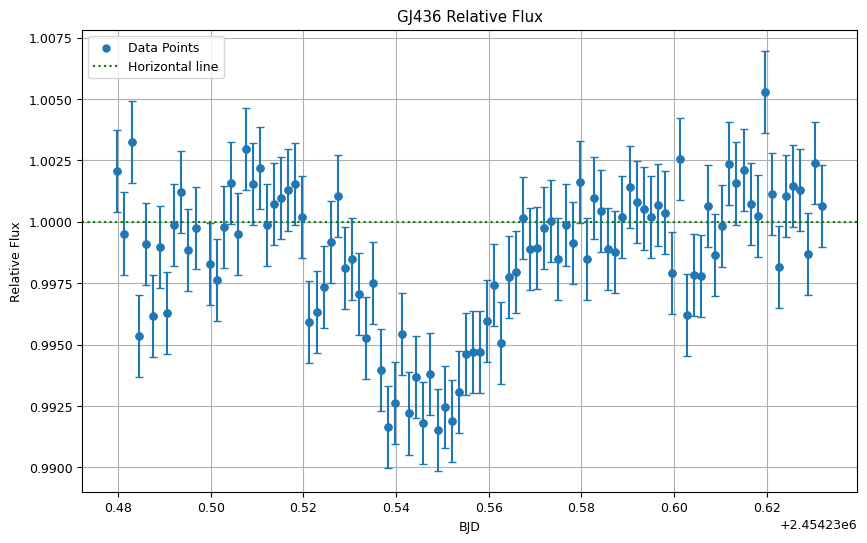

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_Tsit["BJD"], df_Tsit["Relative Flux"], label = 'Data Points')
ax.errorbar(df_Tsit["BJD"], df_Tsit["Relative Flux"], yerr=df_Tsit["RF Error"], fmt='o', capsize=3)
ax.axhline(y=1, color='green', linestyle=':', label='Horizontal line')
ax.grid(True)
ax.legend()
ax.set_xlabel('BJD')
ax.set_ylabel('Relative Flux')
ax.set_title('GJ436 Relative Flux')
plt.show()

Note the green dotted line in the above plot, this will be our reference value to compare transit depth to.

Next, let us clean this data for $2σ$.

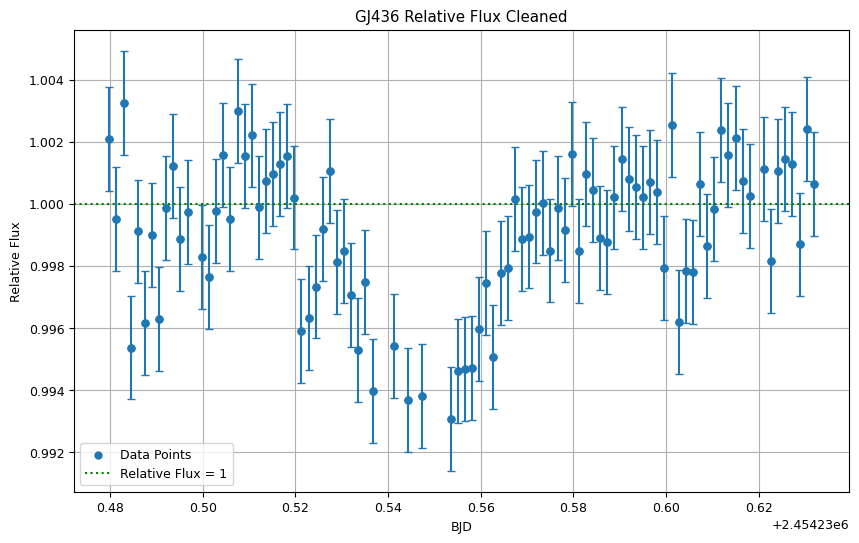

In [ ]:
# Statistics of Data

mean_Tsit = np.mean(df_Tsit["Relative Flux"])
std_Tsit = np.std(df_Tsit["Relative Flux"])

# Filter using Data Stats
df_Tsit_filtered = df_Tsit[np.abs(df_Tsit["Relative Flux"] - mean_Tsit) <= 2 * std_Tsit]

# Plot to see changes
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(df_Tsit_filtered["BJD"], df_Tsit_filtered["Relative Flux"], label = 'Data Points')
plt.errorbar(df_Tsit_filtered["BJD"], df_Tsit_filtered["Relative Flux"], yerr=df_Tsit_filtered["RF Error"], fmt='o', capsize=3)
plt.axhline(y=1, color='green', linestyle=':', label='Relative Flux = 1')
plt.grid(True)
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Relative Flux')
plt.title('GJ436 Relative Flux Cleaned')
plt.show()

In [ ]:
# Check the number of points removed
print(len(df_Tsit)- len(df_Tsit_filtered))

8


With this data cleaned, we can see a clear change in the relative flux provided compared to the normalized value of $1.00$ in our plot.

In [ ]:
df_reset = df_Tsit_filtered.reset_index(drop=True)
print(df_reset)

             BJD  Relative Flux    I  RF Error
0   2.454230e+06       1.002077    1  0.001672
1   2.454230e+06       0.999521    1  0.001672
2   2.454230e+06       1.003258    1  0.001672
3   2.454230e+06       0.995366    1  0.001672
4   2.454230e+06       0.999108    1  0.001672
..           ...            ...  ...       ...
86  2.454231e+06       1.001439    1  0.001672
87  2.454231e+06       1.001277    1  0.001672
88  2.454231e+06       0.998688    1  0.001672
89  2.454231e+06       1.002400    1  0.001672
90  2.454231e+06       1.000630    1  0.001672

[91 rows x 4 columns]


Now we will create a model to take the average of every couple values in the transit to create a basic model for the transit event.

Keep in mind that we were not able to get `pylightcurve` working for the model, so this is why we resorted to creating the model ourselves.

In [ ]:
import numpy as np

# Example data: arrays of x and y points
y = df_reset["Relative Flux"].values

# Calculate the mean of every pair of consecutive points
means = [(y[i] + y[i+1]) / 2 for i in range(len(y)-1)]

means_tsit = []
# Print the results
for mean_y in means:
    means_tsit.append(mean_y)
print(len(means_tsit))

90


In [ ]:
# Determines if length of cuts are same as mean cuts
df_Tsit_cut = df_Tsit_filtered[29:53]
print(len(df_Tsit_cut))
df_mean_tsit = means_tsit[29:53]
print(len(df_mean_tsit))

24
24


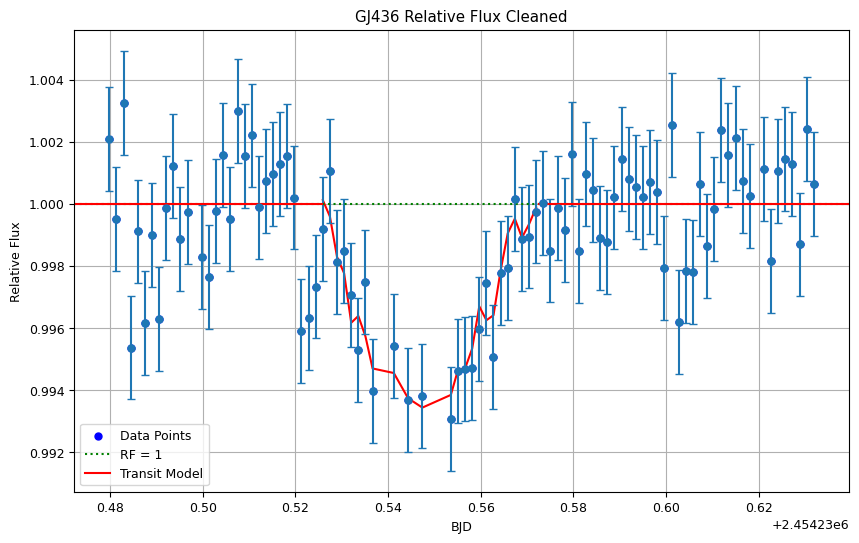

In [ ]:
# Plot to see changes
fig, ax = plt.subplots(figsize=(10, 6))
# Transit Model
plt.plot(df_Tsit_cut["BJD"], df_mean_tsit, color = 'r')
# Filtered Data
plt.scatter(df_Tsit_filtered["BJD"], df_Tsit_filtered["Relative Flux"], color = 'b', label = 'Data Points')
#
plt.errorbar(df_Tsit_filtered["BJD"], df_Tsit_filtered["Relative Flux"], yerr=df_Tsit_filtered["RF Error"], fmt='o', capsize=3)
plt.axhline(y=1, color='green', linestyle=':', label='RF = 1')
plt.axhline(y=1, xmax = 0.32, color='r')
plt.axhline(y=1, xmin = 0.6, color='r', label='Transit Model')
plt.grid(True)
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Relative Flux')
plt.title('GJ436 Relative Flux Cleaned')
plt.show()

With this graph, we can determine the difference between the lowest point of transit depth with the initial value of relative flux, that being $1$. Recall that the transit depth equation is
$$
δ = (\frac{R_p}{R_⋆})^2
$$
where $R_p$ is the radius of the planet, and $R_⋆$ is the radius of the star. We already know the radius of the star given the observables, however in the interest of time, we will take the $R_⋆$ from the website provided [here](https://exoplanet.eu/catalog/gj_436_b--241/).

To determine this value, we will estimate the furthest point from the initial relative flux point to be our maximum transit depth, this will be our value for $δ$. With this, we can isolate $R_p$ and get the following equation:
$$
R_p = R_⋆ \sqrt{δ}
$$
With these parameters in mind, we will now solve for the planet's radius in the equation below.

In [ ]:
R_s = 0.464 * u.R_sun # Units of Radius of the Sun
delta = 1 - min(df_mean_tsit) # Depth is 1 minus the furthest point of relative flux from value

# print(delta)

# Equation
R_p = R_s * np.sqrt(delta)
R_p_final = R_p.to(u.earthRad).value

print("Radius of the Exoplanet is", round(R_p.to(u.earthRad).value,5), "Earth Radii")

Radius of the Exoplanet is 4.10156 Earth Radii


Now, we understand that some of these values may change according to differing transit depths, so we will use multiple values near the boundary of this transit depth. This is further explained in the code below.

In [ ]:
# Sorts Means of transit data from lowest to largest
df_mean_tsit.sort()
# print(df_mean_tsit)

j = 1
tsit_list = []

# Small while loop for determining uncertainty
while j < 5:
  delta = 1 - df_mean_tsit[j]
  R_p = R_s * np.sqrt(delta)
  tsit_list.append(R_p.to(u.earthRad).value)
  # print("Radius of the Exoplanet is", R_p.to(u.jupiterRad).value, "Jupiter Radii")
  j += 1

# Take list and compare them to initial solution
R_p_diff = []
i = 0
for i in range(len(tsit_list)):
  R_p_diff.append(R_p_final - tsit_list[i])
print(R_p_diff)

print("Simple Uncertainty is",round(sum(R_p_diff)/len(R_p_diff),5), "Earth Radii")

[0.09493326699256333, 0.1297678489253995, 0.3640124812060006, 0.39826548969270936]
Simple Uncertainty is 0.24674 Earth Radii


# 3. Calculate the planet density based on the mass and radius measurements.

With both values finally measured, we can finally take the planet density of the GJ 436.

First, we take the basic equation of density, that which is
$$
ρ_p = \frac{M_p}{\frac{4}{3}πR_p^3}
$$
We take this equation and input it for both initial solutions and uncertainties below in the code.

In [ ]:
# Initial Values
Rp_final = 0.36592 * u.jupiterRad # Units of Jupiter Radii
Rp_uncert = 0.02201 * u.jupiterRad # Units of Jupiter Radii
Mp_final = 20.003 * u.earthMass # Units of Earth Mass
Mp_uncert = 1.99963 * u.earthMass # Units of Earth Mass

# Converted to SI units
Rp_final = Rp_final.to(u.m) # Converted to meters
Rp_uncert = Rp_uncert.to(u.m) # Converted to meters
Mp_final = Mp_final.to(u.kg) # Converted to kg
Mp_uncert = Mp_uncert.to(u.kg) # Converted to kg


rho = Mp_final / (4/3 * np.pi * Rp_final**3)
rho_uncert = rho * np.sqrt((Mp_uncert/Mp_final)**2 + (Rp_uncert/Rp_final)**2)


print("Density of Exoplanet is", round(rho.to(u.g / u.cm**3),5))
print("Density uncertainty is" , round(rho_uncert.to(u.g / u.cm**3),5))

Density of Exoplanet is 1.59297 g / cm3
Density uncertainty is 0.18585 g / cm3


# Conclusion

With this, we have our density of the exoplanet GJ 436b.

It has a Mass of approximately $M_{GJ436b} = 20.003 ± 1.9996 \ M_e$ and a radius of approximately $R_{GJ436b} = 4.1016 ± 0.2467 \ R_e$.

It has a density of approximately $ρ_{GJ436b} = 1.5929 ± 0.18585\ g \ cm^{-3}$.

# Appendix A: Installation Packages

This section is for the packages needed to provide some of the values in this notebook. If you are confused as to why pylightcurve is not in this Appendix, well the version used by the professor didn't work with the recent update, so we resorted to producing the model ourself.

In [ ]:
!pip install radvel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 44.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.3/691.3 kB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.8 MB/s eta 0:00:00
  Created wheel for radvel: filename=radvel-1.4.11-cp311-cp311-linux_x86_64.whl size=488285 sha256=65822c42535fff3e20d5f96006412c7c170c6dc1900db0baf

# Appendix B: Broken Data

This section is for anyone interested in broken equations or code. The equation utilized in this section led us down a deep rabbit hole, making us waste time and leading to a large amount of frustration. If anyone wishes to combat this equation themselves, be my guest.

The equation to calculate the planet's mass using radial velocity data:
$$
M_p = \frac{M_⋆(v_r-V_z)}{(\frac{2\pi}{T}(\frac{GM_⋆ T^2}{4π^2})^{\frac{1}{3}}\frac{\sin(i)}{\sqrt{1-e^2}})(\cos(ω+2 \ \tan^{-1}[(\frac{1+e}{1-e})^{\frac{1}{2}}\ \tan(\frac{1}{2})]+e \ \cos(ω)))}
$$

This includes assumptions that the Mass of the star is much larger than the mass of the planet and that the eccentric anomaly is approximately 1.

Parameters within equation are Mass of star $M_⋆$, Radial Velocity $v_r$, Central line of RV $V_z$, Period $T$, Inclination Angle $i$, and Longitude of periastron $ω$, and eccentricity $e$.

We gained our $ω$ value from our Fitting as well as $T$ from our Periodogram and $e$, and $M_⋆$ from our websites.

We need to find the radial velocity measurements of the star from the data collection we're given. From online databases, we can find a whole bunch of data. We can get this data from Simbad as well as other locations. This is the page for the [star](https://simbad.cds.unistra.fr/simbad/sim-id?Ident=GJ436&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) and this is the page for the [planet](https://simbad.cds.unistra.fr/simbad/sim-id?Ident=GJ%20436%20b)

Now, we can use this equation in our code below.

In [ ]:
def P_mass_complex(v_r):
  """
  Creates the equation to find the mass of the planet using Radial Velocity.
  """
  # Parameters
  P = 2.6438 * u.d # Units of days
  e = 0.2 # Unitless
  M_s = 0.452 * u.solMass # Units of Stellar Mass
  G = ac.G # Gravitational Constant
  i = 90 * (2*np.pi)/360 # Degrees to radians
  omega = 326 * np.pi/180 # Convert Degrees to Radians

  mass_list = []

  # Semi-Amplitude
  a = (G*(M_s.to(u.kg))*(P.to(u.s))**2/(4*np.pi**2))**(1/3)
  n = ((2*np.pi)/P.to(u.s))
  K = n * a * np.sin(i) / (1 - e**2)**(1/2) # Units of m / s
  print("This is our value of K:", K)

  # Equations split into smaller equations for ease of translating

  for j in range(len(v_r)):
    # Assumes V_z = 0
    Top = M_s.to(u.kg) * ((v_r.iloc[j] * u.m / u.s) - 0) # Units of kg * (m / s)

    # Frequency
    f = 2 * np.arctan(((1+e) / (1-e)) ** (1/2) * np.tan(1/2) ) # Unitless

    # Solution for Bot
    Bot = K * (np.cos(omega + f) + e * np.cos(omega))

    # Total Equation converted to earth mass
    Eq = ((Top / Bot).to(u.earthMass)).value
    mass_list.append(Eq)

  return(mass_list)

v_r = df_RV_filtered["RV"]
M_p = P_mass_complex(v_r)
# Find Planetary Mass for fitted K value
# print(M_p)
print(sum(M_p)/len(M_p))
# print("Planet has mass of approximately", round(sum(M_p)/len(M_p),3),"Earth Mass")

This is our value of K: 120488.0016276675 m / s
4.027569907957014
